In [1]:
#necessary Libraries
import numpy as np
import pandas as pd
import time
import pprint

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
# magic word for producing visualizations in notebook
%matplotlib inline

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA 
from scipy.sparse import lil_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Scoring Metrics
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [2]:
# Load the dataset
file_path = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\ap_data_8r.csv'
ap_data = pd.read_csv(file_path)

In [3]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = ap_data.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 8
Number of rows: 102082


In [4]:
#check the statistics of the data per columns
ap_data.describe()

,channel,signal_strength,floorid,roomid
count,102082.000000,102082.000000,102082.000000,102082.000000
mean,2437.011461,-72.587322,212.528134,153.658422
std,18.420896,12.922178,104.984371,50.469398
min,2412.000000,-107.000000,1.000000,111.000000
25%,2417.000000,-83.000000,136.000000,111.000000
50%,2437.000000,-72.000000,214.000000,111.000000
75%,2457.000000,-63.000000,305.000000,213.000000
max,2462.000000,-5.000000,376.000000,214.000000


In [5]:
#Check the columns names
col_names = ap_data.columns.values
col_names

array(['mac_address', 'ssid', 'channel', 'source', 'signal_strength',
       'floorid', 'timestamp', 'roomid'], dtype=object)

In [6]:
#check for missing values
missing_values_count = ap_data.isnull().sum()
#uncomment this if you want to see the count of missing data per column
#missing_values_count

# how many total missing values do we have?
total_cells = np.product(ap_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
missing_percent = (total_missing/total_cells) * 100

print('Percent of missing data = {}%'.format(missing_percent))

Percent of missing data = 0.0%


In [7]:
# Add a new column 'source_without_C' by removing 'C' from 'source'
ap_data['ssid'] = ap_data['ssid'].str.replace('C', '')

# Convert the 'source_without_C' column to numeric
ap_data['ssid'] = pd.to_numeric(ap_data['ssid'], errors='coerce')

In [8]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = ap_data["ssid"].unique()
unique_channel = ap_data["channel"].unique()
unique_floorid = ap_data["floorid"].unique()
unique_roomid = ap_data["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel : {}'.format(unique_channel))
print('Unique Floor ID : {}'.format(unique_floorid))
print('Unique Room ID : {}'.format(unique_roomid))

unique_floorid_count = ap_data["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')

Unique SSID : [2 1]
Unique Channel : [2457 2462 2452 2447 2442 2417 2437 2412 2422 2427 2432]
Unique Floor ID : [ 78  69  60  51  42  33  24   7   8  15  16  25  23  32  41  50  59  68
  77   6   5   4   3   2   1  52  43  34  61  70  79  71  62  53  44  35
  26  17   9  10  11  12  13  14  18  20  21  22  27  28  29  30  31  36
  37  38  39  40  45  46  47  48  49  54  55  56  57  58  63  64  65  66
  67  72  73  74  75  76  19 189 188 187 186 185 184 183 182 181 171 172
 173 174 175 176 177 178 179 161 162 163 164 165 166 151 152 153 154 155
 156 141 142 143 144 145 146 131 132 133 134 135 136 121 122 123 124 125
 126 111 112 113 114 115 116 101 102 103 104 105 106 180 167 168 169 170
 157 158 159 160 147 148 149 150 137 138 139 140 127 128 129 130 117 118
 119 120 107 108 109 110 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240

KeyError: 'LONGITUDE'

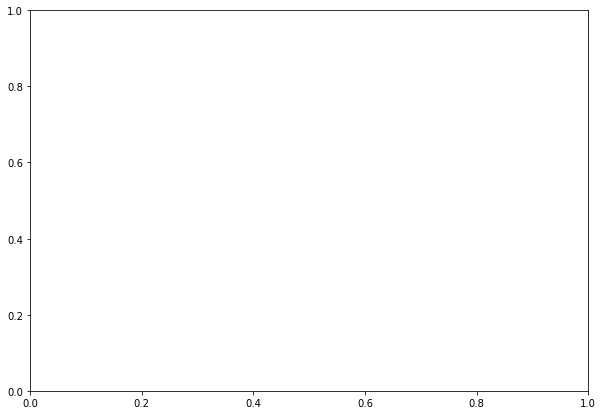

In [9]:
#map the data by user ID
#i.e. see how much of the information in each building was collected by how many users
ap_data.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", alpha=0.4, figsize=(10,7),
    c="USERID", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('user_map_ap_data_8.png')

In [10]:
ap_data = ap_data.drop(['mac_address'], axis=1)

#Check the columns names
col_names = ap_data.columns.values
col_names

array(['ssid', 'channel', 'source', 'signal_strength', 'floorid',
       'timestamp', 'roomid'], dtype=object)

In [46]:
# Define the columns for duplication check
duplication_columns = ['ssid', 'channel', 'source', 'signal_strength', 'floorid']

# Count the number of occurrences for each combination of columns
ap_data['duplication_count'] = ap_data.groupby(duplication_columns)['ssid'].transform('count')

# Filter rows where duplication count is greater than or equal to 4
filtered_data = ap_data[ap_data['duplication_count'] >= 4]

# Save the result to a new CSV file or modify the original dataframe as needed
#filtered_data.to_csv('filtered_data.csv', index=False)

print(filtered_data)

# Group by duplication columns and aggregate values using, for example, the mean
merged_data = filtered_data.groupby(duplication_columns, as_index=False).mean()

# Drop the 'duplication_count' column if you don't need it in the final result
merged_data = merged_data.drop(columns=['duplication_count'])

# Save the result to a new CSV file or modify the original dataframe as needed
#merged_data.to_csv('merged_data.csv', index=False)

print(merged_data)

        ssid  channel source  signal_strength  floorid            timestamp  \
7          1     2462   cap1              -74       78  2023-12-13 16:21:03   
8          2     2462   cap2              -54       78  2023-12-13 16:21:03   
11         1     2462   cap1              -74       78  2023-12-13 16:21:03   
12         2     2462   cap2              -54       78  2023-12-13 16:21:03   
15         1     2462   cap1              -74       78  2023-12-13 16:21:03   
...      ...      ...    ...              ...      ...                  ...   
102076     2     2427   cap3              -66      376  2023-12-13 16:21:02   
102078     1     2432   cap2              -83      376  2023-12-13 16:21:02   
102079     2     2417   cap1              -77      376  2023-12-13 16:21:02   
102080     1     2432   cap1              -91      376  2023-12-13 16:21:02   
102081     1     2432   cap2              -83      376  2023-12-13 16:21:02   

        roomid  duplication_count  
7          214 

In [47]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = merged_data["ssid"].unique()
unique_channel = merged_data["channel"].unique()
unique_floorid = merged_data["floorid"].unique()
unique_roomid = merged_data["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel : {}'.format(unique_channel))
print('Unique Floor ID : {}'.format(unique_floorid))
print('Unique Room ID : {}'.format(unique_roomid))

unique_floorid_count = merged_data["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')


Unique SSID : [1 2]
Unique Channel : [2412 2417 2422 2427 2432 2437 2442 2447 2452 2457 2462]
Unique Floor ID : [219 231 233 190 192 216 217 234 191 218 228 230 222 225 235 333 221 321
 306 349 326 331 351 335 295 315 307 328 332 290 292 342 320 339 343 344
 353 341 334 372 232 214 215 226 229 227 336 371 302 304 220 323 367 297
 299 301 223 313 325 305 345 347 293 309 224 314 296 308 311 312 322 298
 300 350 303 329 294 310 316 346 340 317 318 319 348 338 327 291 366 337
 358 330 324 363 119 365 131 118 148 352 374 195 370 375 277 357 356 354
 359 136 101 145 373 160 163 165 161 121 167 166 175 162 102 134 187 124
 147 127 140 164 186 154 254 170 168 196 368 194 355 376 364 360 361 141
 146 122 125 171 183 133 117 135 113 153 112 181 185 173 120 169 110 362
 151 158 123 150 111 142 155 176 156 106 157 103 172 149 159 174 114 105
 189 107 138 180 108 128 188 130 152 178 193 369 104 143 109 184 144 177
 115 182 126 137 129 179 139 132 116 205 212 263 251 288 269 265 278 275
 274 268 282

In [48]:
# Count unique channels for each ssid, floorid, and source
merge_data = merged_data.groupby(['ssid', 'floorid', 'source'])['channel'].nunique().reset_index()

print(merge_data)

      ssid  floorid source  channel
0        1        1   cap1        2
1        1        1   cap2        3
2        1        2   cap1        1
3        1        2   cap2        2
4        1        3   cap1        3
...    ...      ...    ...      ...
1507     2      374   cap2        1
1508     2      374   cap3        3
1509     2      375   cap3        3
1510     2      376   cap1        2
1511     2      376   cap3        3

[1512 rows x 4 columns]


In [49]:
# Define a custom aggregation function to calculate the product
def calculate_product(x):
    return x.prod()

# Group by 'ssid' and 'floorid', then aggregate using the custom function
result = merge_data.groupby(['ssid', 'floorid']).agg({
    'channel': calculate_product
}).reset_index()

# Display the result
print(result)

# Continue from the previous code
total_sum_combination = result['channel'].sum()

# Display the total sum
print("Total Sum of 'channel' values:", total_sum_combination)


     ssid  floorid  channel
0       1        1        6
1       1        2        2
2       1        3        6
3       1        4        3
4       1        5        9
..    ...      ...      ...
704     2      372        6
705     2      373       16
706     2      374        3
707     2      375        3
708     2      376        6

[709 rows x 3 columns]
Total Sum of 'channel' values: 4079


In [50]:
# Count the number of unique sources per 'ssid' and 'floorid'
result_counts = merge_data.groupby(['ssid', 'floorid'])['source'].nunique().reset_index()

# Rename the column to indicate the count of sources
result_counts = result_counts.rename(columns={'source': 'source_count'})

# Display the result
print(result_counts)

# Save the result to a new CSV file or modify the original dataframe as needed
#result_counts.to_csv('source_count.csv', index=False)

     ssid  floorid  source_count
0       1        1             2
1       1        2             2
2       1        3             2
3       1        4             2
4       1        5             2
..    ...      ...           ...
704     2      372             2
705     2      373             3
706     2      374             3
707     2      375             1
708     2      376             2

[709 rows x 3 columns]


In [51]:
# Calculate total RSSI for each unique channel within each ssid, floorid, and source
total_number_rssi = merged_data.groupby(['ssid', 'floorid', 'source', 'channel'])['signal_strength'].nunique().reset_index()

print(total_number_rssi)

      ssid  floorid source  channel  signal_strength
0        1        1   cap1     2457                2
1        1        1   cap1     2462                6
2        1        1   cap2     2452                3
3        1        1   cap2     2457                2
4        1        1   cap2     2462                3
...    ...      ...    ...      ...              ...
3384     2      376   cap1     2412                1
3385     2      376   cap1     2417                2
3386     2      376   cap3     2412                2
3387     2      376   cap3     2417                2
3388     2      376   cap3     2427                8

[3389 rows x 5 columns]


In [52]:
print(merged_data)

      ssid  channel source  signal_strength  floorid  roomid
0        1     2412   cap1              -94      219     111
1        1     2412   cap1              -93      231     111
2        1     2412   cap1              -93      233     111
3        1     2412   cap1              -92      190     111
4        1     2412   cap1              -92      192     111
...    ...      ...    ...              ...      ...     ...
8099     2     2462   cap3              -71      211     111
8100     2     2462   cap3              -67      212     111
8101     2     2462   cap3              -65      205     111
8102     2     2462   cap3              -64      205     111
8103     2     2462   cap3              -62      205     111

[8104 rows x 6 columns]


In [53]:
import pandas as pd
from itertools import product

start_time = time.time()


# Step 1: Identify missing sources and add rows with 0 channel and 100 signal_strength


# List of sources to check for each ssid and floorid combination
sources_to_check = ['cap1', 'cap2', 'cap3']

# Create a MultiIndex from ssid and floorid
index_cols = ['ssid', 'floorid']
multi_index = pd.MultiIndex.from_frame(merged_data[index_cols])

# Iterate over unique ssid and floorid combinations
for ssid, floorid in multi_index.unique():
    # Filter data for the current ssid and floorid
    subset = merged_data[(merged_data['ssid'] == ssid) & (merged_data['floorid'] == floorid)]
    
    # Get the sources present in the subset
    present_sources = subset['source'].unique()
    
    # Find the missing sources
    missing_sources = set(sources_to_check) - set(present_sources)
    
    # Add rows for missing sources
    for missing_source in missing_sources:
        merged_data = merged_data.append({
            'ssid': ssid,
            'channel': 0,
            'source': missing_source,
            'signal_strength': 100,
            'floorid': floorid,
            'roomid': subset['roomid'].iloc[0]  # Assuming roomid is the same for all rows in the subset
        }, ignore_index=True)

# Sort the DataFrame by ssid and floorid
merged_data = merged_data.sort_values(by=['ssid', 'floorid']).reset_index(drop=True)

# Remove rows where ssid is 0
merged_data = merged_data[merged_data['ssid'] != 0]

# Display the result
print(merged_data)

#merged_data.to_csv('merged_data_with_0.csv', index=False)

print(merged_data)

# Step 2: Extract unique combinations of 'ssid', 'floorid', and 'roomid'
combinations = merged_data[['ssid', 'floorid', 'roomid']].drop_duplicates()

# Step 3: Calculate unique channels for each source
channel_counts = {}
for index, row in combinations.iterrows():
    ssid, floorid, roomid = row['ssid'], row['floorid'], row['roomid']
    channels = merged_data[(merged_data['ssid'] == ssid) & 
                           (merged_data['floorid'] == floorid) & 
                           (merged_data['roomid'] == roomid)].groupby('source')['channel'].unique()
    channel_counts[(ssid, floorid, roomid)] = channels

print(channel_counts)

# Step 4 and 5: Generate combinations and create DataFrame
combinations_list = []
for (ssid, floorid, roomid), channels in channel_counts.items():
    for source, channel_list in channels.items():
        for channel in channel_list:
            signal_strengths = merged_data[
                (merged_data['ssid'] == ssid) &
                (merged_data['floorid'] == floorid) &
                (merged_data['roomid'] == roomid) &
                (merged_data['source'] == source) &
                (merged_data['channel'] == channel)
            ]['signal_strength'].tolist()

            total_signal_strengths = len(signal_strengths)

            print(f'SSID: {ssid}, FloorID: {floorid}, RoomID: {roomid}, Total Number of Signal Strength for {source} channel {channel}: {total_signal_strengths}')

            combination = [ssid, floorid, roomid, source, f'channel_{channel}_signal_strength_{source}', signal_strengths]
            combinations_list.append(combination)

            
print(combinations_list)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

      ssid  channel source  signal_strength  floorid  roomid
0        1     2452   cap2              -65        1     214
1        1     2452   cap2              -64        1     214
2        1     2452   cap2              -63        1     214
3        1     2457   cap1              -80        1     214
4        1     2457   cap1              -74        1     214
...    ...      ...    ...              ...      ...     ...
8714     2     2427   cap3              -62      376     111
8715     2     2427   cap3              -61      376     111
8716     2     2427   cap3              -60      376     111
8717     2     2427   cap3              -58      376     111
8718     2        0   cap2              100      376     111

[8719 rows x 6 columns]
      ssid  channel source  signal_strength  floorid  roomid
0        1     2452   cap2              -65        1     214
1        1     2452   cap2              -64        1     214
2        1     2452   cap2              -63        1     214

SSID: 1, FloorID: 7, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 6
SSID: 1, FloorID: 7, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 8, RoomID: 214, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 1, FloorID: 8, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 6
SSID: 1, FloorID: 8, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 2
SSID: 1, FloorID: 8, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 1, FloorID: 8, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 9, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 1, FloorID: 9, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 4
SSID: 1, FloorID: 9, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 1, FloorID: 9, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1,

SSID: 1, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 2
SSID: 1, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 5
SSID: 1, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 38, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 5
SSID: 1, FloorID: 38, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 1, FloorID: 38, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 1, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 1, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 40, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 1, FloorID: 40, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462:

SSID: 1, FloorID: 65, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 2
SSID: 1, FloorID: 65, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 66, RoomID: 214, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 1, FloorID: 66, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 4
SSID: 1, FloorID: 66, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 5
SSID: 1, FloorID: 66, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 67, RoomID: 214, Total Number of Signal Strength for cap1 channel 2452: 2
SSID: 1, FloorID: 67, RoomID: 214, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 1, FloorID: 67, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 6
SSID: 1, FloorID: 67, RoomID: 214, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 1, FloorID: 67, RoomID: 214, Total Number of Signal Strength for cap2 channel 24

SSID: 1, FloorID: 109, RoomID: 213, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 1, FloorID: 109, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 1, FloorID: 109, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap1 channel 2432: 1
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 2
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 4
SSID: 1, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 1, FloorID: 111, RoomID: 213, Total Number of Signal Strength fo

SSID: 1, FloorID: 130, RoomID: 213, Total Number of Signal Strength for cap1 channel 2452: 2
SSID: 1, FloorID: 130, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 2
SSID: 1, FloorID: 130, RoomID: 213, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 1, FloorID: 130, RoomID: 213, Total Number of Signal Strength for cap3 channel 2432: 2
SSID: 1, FloorID: 130, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 2
SSID: 1, FloorID: 130, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap1 channel 2422: 1
SSID: 1, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 1, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap2 channel 2427: 1
SSID: 1, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 1, FloorID: 131, RoomID: 213, Total Number of Signal Strength fo

SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap1 channel 2437: 3
SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap2 channel 2432: 2
SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 1
SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 145, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 3
SSID: 1, FloorID: 146, RoomID: 213, Total Number of Signal Strength for cap1 channel 2432: 1
SSID: 1, FloorID: 146, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 3
SSID: 1, FloorID: 146, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 1, FloorID: 146, RoomID: 213, Total Number of Signal Strength fo

SSID: 1, FloorID: 161, RoomID: 213, Total Number of Signal Strength for cap2 channel 2427: 3
SSID: 1, FloorID: 161, RoomID: 213, Total Number of Signal Strength for cap2 channel 2432: 3
SSID: 1, FloorID: 161, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 3
SSID: 1, FloorID: 161, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 4
SSID: 1, FloorID: 161, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 4
SSID: 1, FloorID: 162, RoomID: 213, Total Number of Signal Strength for cap1 channel 2437: 1
SSID: 1, FloorID: 162, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 1, FloorID: 162, RoomID: 213, Total Number of Signal Strength for cap2 channel 2427: 1
SSID: 1, FloorID: 162, RoomID: 213, Total Number of Signal Strength for cap2 channel 2432: 2
SSID: 1, FloorID: 162, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 2
SSID: 1, FloorID: 162, RoomID: 213, Total Number of Signal Strength fo

SSID: 1, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 3
SSID: 1, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 3
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap2 channel 2452: 2
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 5
SSID: 1, FloorID: 180, RoomID: 213, Total Number of Signal Strength fo

SSID: 1, FloorID: 198, RoomID: 111, Total Number of Signal Strength for cap3 channel 2442: 2
SSID: 1, FloorID: 198, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 5
SSID: 1, FloorID: 198, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 4
SSID: 1, FloorID: 199, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 199, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 199, RoomID: 111, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 199, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 2
SSID: 1, FloorID: 199, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 5
SSID: 1, FloorID: 199, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 3
SSID: 1, FloorID: 200, RoomID: 111, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 1, FloorID: 200, RoomID: 111, Total Number of Signal Strength for cap2

SSID: 1, FloorID: 225, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 1, FloorID: 225, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 1, FloorID: 225, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 225, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 4
SSID: 1, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 6
SSID: 1, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 3
SSID: 1, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 1, FloorID: 227, RoomID: 111, Total Number of Signal Strength for cap1

SSID: 1, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 3
SSID: 1, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 1, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 3
SSID: 1, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 1, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 1, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 3
SSID: 1, FloorID: 253, RoomID: 111, Total Number of Signal Strength for cap1

SSID: 1, FloorID: 271, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 4
SSID: 1, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 5
SSID: 1, FloorID: 273, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 273, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 273, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 1, FloorID: 274, RoomID: 111, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 1, FloorID: 274, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 274, RoomID: 111, Total Number of Signal Strength for cap3 channel 

SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 5
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 2
SSID: 1, FloorID: 296, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 296, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 296, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 1, FloorID: 296, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 5
SSID: 1, FloorID: 296, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 296, RoomID: 111, Total Number of Signal Strength for cap3 ch

SSID: 1, FloorID: 317, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 1, FloorID: 317, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 317, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 5
SSID: 1, FloorID: 318, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 318, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 318, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 1, FloorID: 318, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 1
SSID: 1, FloorID: 318, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 318, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 5
SSID: 1, FloorID: 319, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 319, RoomID: 111, Total Number of Signal Strength for cap2 ch

SSID: 1, FloorID: 340, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 340, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 340, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 1, FloorID: 340, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 7
SSID: 1, FloorID: 341, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 341, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 1
SSID: 1, FloorID: 341, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 341, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 1, FloorID: 341, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 341, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 4
SSID: 1, FloorID: 342, RoomID: 111, Total Number of Signal Strength for cap1

SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap1 channel 2432: 1
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap1 channel 2437: 2
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap1 channel 2442: 4
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap2 channel 2432: 3
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap3 channel 2432: 1
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 2
SSID: 1, FloorID: 356, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 2
SSID: 1, FloorID: 357, RoomID: 111, Total Number of Signal Strength for cap1 channel 2427: 1
SSID: 1, FloorID: 357, RoomID: 111, Total Number of Signal Strength for cap1 channel 2432: 4
SSID: 1, FloorID: 357, RoomID: 111, Total Number of Signal Strength fo

SSID: 1, FloorID: 372, RoomID: 111, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 372, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 1, FloorID: 372, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap1 channel 2432: 1
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap1 channel 2437: 5
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap2 channel 2427: 2
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap2 channel 2432: 5
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 373, RoomID: 111, Total Number of Signal Strength fo

SSID: 2, FloorID: 17, RoomID: 214, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 17, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 2
SSID: 2, FloorID: 17, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 5
SSID: 2, FloorID: 17, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 18, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 18, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 18, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 6
SSID: 2, FloorID: 18, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 19, RoomID: 214, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 19, RoomID: 214, Total Number of Signal Strength for cap2 channel 2412: 1
SSID: 2, FloorID: 19, RoomID: 214, Total Number of Signal Strength for cap2 channel 2417:

SSID: 2, FloorID: 43, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 5
SSID: 2, FloorID: 43, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 43, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 5
SSID: 2, FloorID: 43, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 44, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 4
SSID: 2, FloorID: 44, RoomID: 214, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 2, FloorID: 44, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 2, FloorID: 44, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 45, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 45, RoomID: 214, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 2, FloorID: 45, RoomID: 214, Total Number of Signal Strength for cap2 channel 24

SSID: 2, FloorID: 68, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 68, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 69, RoomID: 214, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 2, FloorID: 69, RoomID: 214, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 69, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 69, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 69, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 70, RoomID: 214, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 70, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 5
SSID: 2, FloorID: 70, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 70, RoomID: 214, Total Number of Signal Strength for cap2 channel 24

SSID: 2, FloorID: 109, RoomID: 213, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 2
SSID: 2, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 2
SSID: 2, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 2, FloorID: 110, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 1
SSID: 2, FloorID: 111, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 4
SSID: 2, FloorID: 111, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 1
SSID: 2, FloorID: 111, RoomID: 213, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 2, FloorID: 111, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 3
SSID: 2, FloorID: 111, RoomID: 213, Total Number of Signal Strength for c

SSID: 2, FloorID: 127, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 6
SSID: 2, FloorID: 127, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 3
SSID: 2, FloorID: 128, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 128, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 4
SSID: 2, FloorID: 128, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 128, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 128, RoomID: 213, Total Number of Signal Strength for cap3 channel 2457: 1
SSID: 2, FloorID: 128, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 5
SSID: 2, FloorID: 129, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 129, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 129, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 149, RoomID: 213, Total Number of Signal Strength for cap3 channel 2457: 1
SSID: 2, FloorID: 149, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 5
SSID: 2, FloorID: 150, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 2, FloorID: 150, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 150, RoomID: 213, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 2, FloorID: 150, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 3
SSID: 2, FloorID: 150, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 2, FloorID: 150, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 5
SSID: 2, FloorID: 151, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 5
SSID: 2, FloorID: 151, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 2
SSID: 2, FloorID: 151, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 5
SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap3 channel 2457: 2
SSID: 2, FloorID: 169, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 2
SSID: 2, FloorID: 170, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 170, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 2, FloorID: 170, RoomID: 213, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 2, FloorID: 170, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 186, RoomID: 213, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 186, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 2
SSID: 2, FloorID: 186, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 2
SSID: 2, FloorID: 187, RoomID: 213, Total Number of Signal Strength for cap1 channel 2437: 1
SSID: 2, FloorID: 187, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 2, FloorID: 187, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 2, FloorID: 187, RoomID: 213, Total Number of Signal Strength for cap2 channel 2452: 2
SSID: 2, FloorID: 187, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 2, FloorID: 187, RoomID: 213, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 2, FloorID: 188, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 3
SSID: 2, FloorID: 188, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 205, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 3
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap1 channel 2452: 3
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 2
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 2
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 5
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 1
SSID: 2, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 2, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 2, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap3

SSID: 2, FloorID: 226, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 6
SSID: 2, FloorID: 227, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 2
SSID: 2, FloorID: 227, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 227, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 3
SSID: 2, FloorID: 227, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 4
SSID: 2, FloorID: 227, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 3
SSID: 2, FloorID: 228, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 4
SSID: 2, FloorID: 228, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 228, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 228, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 228, RoomID: 111, Total Number of Signal Strength for cap3

SSID: 2, FloorID: 250, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 3
SSID: 2, FloorID: 251, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 2
SSID: 2, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 252, RoomID: 111, Total Number of Signal Strength for cap3 ch

SSID: 2, FloorID: 276, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 276, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 2, FloorID: 276, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 2
SSID: 2, FloorID: 277, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 2, FloorID: 277, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 277, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 277, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 277, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 2
SSID: 2, FloorID: 277, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 2, FloorID: 278, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 278, RoomID: 111, Total Number of Signal Strength for cap2

SSID: 2, FloorID: 301, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 301, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 2, FloorID: 302, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 302, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 302, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 302, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 5
SSID: 2, FloorID: 302, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 5
SSID: 2, FloorID: 303, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 303, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 303, RoomID: 111, Total Number of Signal Strength for cap1 channel 2422: 1
SSID: 2, FloorID: 303, RoomID: 111, Total Number of Signal Strength for cap2

SSID: 2, FloorID: 327, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 327, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 327, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 327, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 2, FloorID: 328, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 4
SSID: 2, FloorID: 328, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 328, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 328, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 4
SSID: 2, FloorID: 329, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 329, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 329, RoomID: 111, Total Number of Signal Strength for cap3 ch

SSID: 2, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 4
SSID: 2, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 2
SSID: 2, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 2
SSID: 2, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 2, FloorID: 354, RoomID: 111, Total Number of Signal Strength for cap1 channel 2422: 2
SSID: 2, FloorID: 354, RoomID: 111, Total Number of Signal Strength fo

SSID: 2, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 1
SSID: 2, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 373, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 6
SSID: 2, FloorID: 374, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 2, FloorID: 374, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 1
SSID: 2, FloorID: 374, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 3
SSID: 2, FloorID: 374, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 374, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 4
SSID: 2, FloorID: 375, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 375, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 375, RoomID: 111, Total Number of Signal Strength for cap3

In [54]:
# Assuming the 'roomid' column is present in the 'merged_data' DataFrame

# Step 6: Combine the RSSI from each row
combined_rssi = pd.DataFrame(columns=['ssid', 'floorid', 'roomid', 'channel_cap1', 'channel_cap2', 'channel_cap3', 'signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'])

for (ssid, floorid, roomid), channels in channel_counts.items():
    product_list = product(*(channels[source] for source in channels.keys()))

    for combination in product_list:
        row = {'ssid': ssid, 'floorid': floorid, 'roomid': merged_data[(merged_data['ssid'] == ssid) & (merged_data['floorid'] == floorid)]['roomid'].values[0]}
        for i, (source, channel) in enumerate(zip(channels.keys(), combination), start=1):
            row[f'channel_{source}'] = channel
            signal_strengths = merged_data[
                (merged_data['ssid'] == ssid) &
                (merged_data['floorid'] == floorid) &
                (merged_data['source'] == source) &
                (merged_data['channel'] == channel)
            ]['signal_strength'].tolist()

            row[f'signal_strength_cap{i}'] = signal_strengths if signal_strengths else None

        combined_rssi = combined_rssi.append(row, ignore_index=True)

print(combined_rssi)
#combined_rssi.to_csv('combined_rssi_knn.csv', index=False)

     ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0       1       1    214         2457         2452            0   
1       1       1    214         2457         2457            0   
2       1       1    214         2457         2462            0   
3       1       1    214         2462         2452            0   
4       1       1    214         2462         2457            0   
...   ...     ...    ...          ...          ...          ...   
4074    2     376    111         2412            0         2417   
4075    2     376    111         2412            0         2427   
4076    2     376    111         2417            0         2412   
4077    2     376    111         2417            0         2417   
4078    2     376    111         2417            0         2427   

                signal_strength_cap1 signal_strength_cap2  \
0                         [-80, -74]      [-65, -64, -63]   
1                         [-80, -74]           [-63, -58]   
2           

In [55]:
# Step 7: Combine the RSSI from each row
combined_rssi_final = pd.DataFrame(columns=combined_rssi.columns)  # Initialize an empty DataFrame

for index, row in combined_rssi.head(total_sum_combination).iterrows():  # Iterate only over the first 9 rows
    ssid, floorid, roomid, channel_cap1, channel_cap2, channel_cap3 = row['ssid'], row['floorid'], row['roomid'], row['channel_cap1'], row['channel_cap2'], row['channel_cap3']
    
    # Create all possible combinations of signal strengths
    signal_strengths = [row['signal_strength_cap1'], row['signal_strength_cap2'], row['signal_strength_cap3']]
    
    # Handle the case where signal strength is an integer (100)
    signal_combinations = [signal if isinstance(signal, list) else [signal] for signal in signal_strengths]
    
    for signal_combination in product(*signal_combinations):
        combined_rssi_final = combined_rssi_final.append({
            'ssid': ssid,
            'floorid': floorid,
            'roomid': roomid,
            'channel_cap1': channel_cap1,
            'channel_cap2': channel_cap2,
            'channel_cap3': channel_cap3,
            'signal_strength_cap1': signal_combination[0],
            'signal_strength_cap2': signal_combination[1],
            'signal_strength_cap3': signal_combination[2]
        }, ignore_index=True)

# Display the result
print(combined_rssi_final)

#combined_rssi_final.to_csv('combined_rssi_final_testing.csv', index=False)


      ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0        1       1    214         2457         2452            0   
1        1       1    214         2457         2452            0   
2        1       1    214         2457         2452            0   
3        1       1    214         2457         2452            0   
4        1       1    214         2457         2452            0   
...    ...     ...    ...          ...          ...          ...   
30498    2     376    111         2417            0         2427   
30499    2     376    111         2417            0         2427   
30500    2     376    111         2417            0         2427   
30501    2     376    111         2417            0         2427   
30502    2     376    111         2417            0         2427   

      signal_strength_cap1 signal_strength_cap2 signal_strength_cap3  
0                      -80                  -65                  100  
1                      -80               

In [56]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = combined_rssi_final.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 9
Number of rows: 30503


In [57]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = combined_rssi_final["ssid"].unique()
unique_channel_cap1 = combined_rssi_final["channel_cap1"].unique()
unique_channel_cap2 = combined_rssi_final["channel_cap2"].unique()
unique_channel_cap3 = combined_rssi_final["channel_cap3"].unique()
unique_floorid = combined_rssi_final["floorid"].unique()
unique_roomid = combined_rssi_final["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel cap1 : {}'.format(unique_channel_cap1))
print('Unique Channel cap2: {}'.format(unique_channel_cap2))
print('Unique Channel cap3: {}'.format(unique_channel_cap3))

# Assuming unique_floorid is a NumPy array or a pandas Series
unique_floorid_sorted = np.sort(unique_floorid)

print('Unique Floor ID (Sorted):', unique_floorid_sorted)

print('Unique Room ID : {}'.format(unique_roomid))

unique_channels_combined = np.union1d(np.union1d(unique_channel_cap1, unique_channel_cap2), unique_channel_cap3)

print('Unique Channel combined:', unique_channels_combined)

unique_floorid_count = combined_rssi_final["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')

Unique SSID : [1 2]
Unique Channel cap1 : [2457 2462 2452 0 2427 2432 2442 2447 2437 2422 2412 2417]
Unique Channel cap2: [2452 2457 2462 2447 2432 2437 2427 2442 2422 2412 0 2417]
Unique Channel cap3: [0 2462 2437 2442 2432 2447 2427 2412 2417 2422 2457 2452]
Unique Floor ID (Sorted): [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219

In [58]:
#Preprocess the Training Data Set //////////////////////////////////////////////////////////////////////////////////////////////

In [98]:
# Load the dataset
#file_path = combined_rssi_final
trainingData = combined_rssi_final

print(trainingData)

      ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0        1       1    214         2457         2452            0   
1        1       1    214         2457         2452            0   
2        1       1    214         2457         2452            0   
3        1       1    214         2457         2452            0   
4        1       1    214         2457         2452            0   
...    ...     ...    ...          ...          ...          ...   
30498    2     376    111         2417            0         2427   
30499    2     376    111         2417            0         2427   
30500    2     376    111         2417            0         2427   
30501    2     376    111         2417            0         2427   
30502    2     376    111         2417            0         2427   

      signal_strength_cap1 signal_strength_cap2 signal_strength_cap3  
0                      -80                  -65                  100  
1                      -80               

In [99]:
def clean_data(df):
    """
    Perform feature trimming, and engineering for trainingData
    Will also be applied to validationData
    
    INPUT: trainingData DataFrame
    OUTPUT: Trimmed and cleaned trainingData DataFrame
    """
    
    # Reverse the representation for the values. 100=0 and teh values range from 0-105 (weakest to strongest)
    #"The intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM.
    #The positive value 100 is used to denote when a WAP was not detected."
    
    '''
    df.iloc[:, 5:8] = np.where(df.iloc[:, 5:8] <= 0, 
                df.iloc[:, 5:8] + 105, 
                df.iloc[:, 5:8] - 100)
    '''
    
    '''
    df.iloc[:, 6:9] = np.where(df.iloc[:, 6:9] > 2000, 
                df.iloc[:, 6:9] - 2300, 
                df.iloc[:, 6:9] - 0)
    '''
    
    '''  
    # Remove rows if there are two zeroes in a row in the cap_channel
    df = df[
    ~((df['channel_cap1'] == 0) & (df['channel_cap2'] == 0)) &
    ~((df['channel_cap1'] == 0) & (df['channel_cap3'] == 0)) &
    ~((df['channel_cap2'] == 0) & (df['channel_cap3'] == 0))
    ]

     
    # Remove rows if there are one zeroes in a row in the cap_channel
    df = df[
    ~((df['channel_cap1'] == 0)) &
    ~((df['channel_cap2'] == 0)) &
    ~((df['channel_cap3'] == 0)) 
    ]
    ''' 

    # Return the cleaned dataframe.
    return df 

In [100]:
#Apply Cleaning

trainingData  = clean_data(trainingData)


#trainingData.to_csv('trainingData-ap_data_ap_data_8.csv', index=False)

print(trainingData)

      ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0        1       1    214         2457         2452            0   
1        1       1    214         2457         2452            0   
2        1       1    214         2457         2452            0   
3        1       1    214         2457         2452            0   
4        1       1    214         2457         2452            0   
...    ...     ...    ...          ...          ...          ...   
30498    2     376    111         2417            0         2427   
30499    2     376    111         2417            0         2427   
30500    2     376    111         2417            0         2427   
30501    2     376    111         2417            0         2427   
30502    2     376    111         2417            0         2427   

      signal_strength_cap1 signal_strength_cap2 signal_strength_cap3  
0                      -80                  -65                  100  
1                      -80               

In [101]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = trainingData["ssid"].unique()
unique_channel_cap1 = trainingData["channel_cap1"].unique()
unique_channel_cap2 = trainingData["channel_cap2"].unique()
unique_channel_cap3 = trainingData["channel_cap3"].unique()
unique_floorid = trainingData["floorid"].unique()
unique_roomid = trainingData["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel cap1 : {}'.format(unique_channel_cap1))
print('Unique Channel cap2: {}'.format(unique_channel_cap2))
print('Unique Channel cap3: {}'.format(unique_channel_cap3))

# Assuming unique_floorid is a NumPy array or a pandas Series
unique_floorid_sorted = np.sort(unique_floorid)

print('Unique Floor ID (Sorted):', unique_floorid_sorted)

print('Unique Room ID : {}'.format(unique_roomid))

unique_channels_combined = np.union1d(np.union1d(unique_channel_cap1, unique_channel_cap2), unique_channel_cap3)

print('Unique Channel combined:', unique_channels_combined)

unique_floorid_count = trainingData["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')

Unique SSID : [1 2]
Unique Channel cap1 : [2457 2462 2452 0 2427 2432 2442 2447 2437 2422 2412 2417]
Unique Channel cap2: [2452 2457 2462 2447 2432 2437 2427 2442 2422 2412 0 2417]
Unique Channel cap3: [0 2462 2437 2442 2432 2447 2427 2412 2417 2422 2457 2452]
Unique Floor ID (Sorted): [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219

In [82]:
# Group the data by "floorid" and count the number of rows for each unique floor ID
floorid_counts = trainingData.groupby('floorid').size()

# Convert the Series to a DataFrame with 'floorid' as index
floorid_counts_df = floorid_counts.reset_index(name='row_count')

# Display the number of rows for each unique floor ID
print("Number of Rows for Each Unique Floor ID:")
print(floorid_counts_df)

# Export the DataFrame to CSV
#floorid_counts_df.to_csv('floorid_counts.csv', index=False)

Number of Rows for Each Unique Floor ID:
     floorid  row_count
0          1        128
1          2         16
2          3         55
3          4         40
4          5         40
..       ...        ...
350      372         96
351      373        516
352      374        456
353      375         91
354      376        236

[355 rows x 2 columns]


In [83]:
import pandas as pd

# Load the dataset
trainingData = combined_rssi_final

# Calculate the row counts for each floorid
floorid_counts = trainingData.groupby('floorid').size().reset_index(name='row_count')

# Find the maximum number of rows associated with any floorid
max_rows = floorid_counts['row_count'].max()

# Create an empty DataFrame to store duplicated rows
duplicated_rows = pd.DataFrame()

# Iterate over unique floorids
for floorid, row_count in floorid_counts[['floorid', 'row_count']].values:
    # Calculate the number of duplications required to match the max_rows
    num_duplicates = max_rows - row_count
    
    # If the current number of rows is less than max_rows, duplicate the rows
    if num_duplicates > 0:
        # Filter rows for the current floorid
        floorid_rows = trainingData[trainingData['floorid'] == floorid]
        
        # Duplicate rows and append to the duplicated_rows DataFrame
        duplicated_rows = pd.concat([duplicated_rows, floorid_rows.sample(n=num_duplicates, replace=True)])
        
# Concatenate the original dataset with duplicated rows
balanced_trainingData = pd.concat([trainingData, duplicated_rows])

# Sort the DataFrame by floorid for clarity
balanced_trainingData = balanced_trainingData.sort_values(by='floorid').reset_index(drop=True)

# Display the balanced dataset
print(balanced_trainingData)

#balanced_trainingData.to_csv('balanced_trainingData.csv', index=False)

       ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0         1       1    214         2457         2452            0   
1         1       1    214         2462         2462            0   
2         2       1    214         2457         2462            0   
3         1       1    214         2462         2462            0   
4         1       1    214         2462         2462            0   
...     ...     ...    ...          ...          ...          ...   
248495    2     376    111         2417            0         2427   
248496    2     376    111         2417            0         2427   
248497    1     376    111         2432         2432         2447   
248498    1     376    111         2432         2432         2437   
248499    2     376    111         2412            0         2427   

       signal_strength_cap1 signal_strength_cap2 signal_strength_cap3  
0                       -80                  -65                  100  
1                       -77

In [84]:
# Group the data by "floorid" and count the number of rows for each unique floor ID
floorid_counts = balanced_trainingData.groupby('floorid').size()

# Convert the Series to a DataFrame with 'floorid' as index
floorid_counts_df = floorid_counts.reset_index(name='row_count')

# Display the number of rows for each unique floor ID
print("Number of Rows for Each Unique Floor ID:")
print(floorid_counts_df)

# Export the DataFrame to CSV
#floorid_counts_df.to_csv('floorid_counts-balanced_trainingData.csv', index=False)

Number of Rows for Each Unique Floor ID:
     floorid  row_count
0          1        700
1          2        700
2          3        700
3          4        700
4          5        700
..       ...        ...
350      372        700
351      373        700
352      374        700
353      375        700
354      376        700

[355 rows x 2 columns]


In [102]:
import pandas as pd

def preprocess_data(df):
    """
    Separates trainingData into Features and Targets
    Will also be applied to validationData
    
    INPUT: Cleaned trainingData DataFrame
    OUTPUT: trainingData as Features and Targets
    """
    # split the data set into features and targets(Floor and BuildingID)
    X = df.drop(['floorid', 'roomid'], axis=1)
    y = df[['roomid']]
    
    # Extract unique channel values
    unique_channels = sorted(set(df['channel_cap1'].unique()) | set(df['channel_cap2'].unique()) | set(df['channel_cap3'].unique()))
    
    # Create new one-hot encoded columns
    for channel in unique_channels:
        X[f'channel_cap1_{channel}'] = (df['channel_cap1'] == channel).astype(int)
        X[f'channel_cap2_{channel}'] = (df['channel_cap2'] == channel).astype(int)
        X[f'channel_cap3_{channel}'] = (df['channel_cap3'] == channel).astype(int)
    
    # Drop the original 'channel_cap1', 'channel_cap2', and 'channel_cap3' columns
    X.drop(['channel_cap1', 'channel_cap2', 'channel_cap3'], axis=1, inplace=True)
    
    # Iterate over signal strength caps and channels to perform multiplication
    signal_columns = ['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3']
    
    for signal_col in signal_columns:
        for channel in unique_channels:
            channel_col1 = f'channel_cap1_{channel}'
            channel_col2 = f'channel_cap2_{channel}'
            channel_col3 = f'channel_cap3_{channel}'
            
            if signal_col.endswith('cap1'):
                X[f'{signal_col}_{channel_col1}'] = df[signal_col] * X[channel_col1]
            elif signal_col.endswith('cap2'):
                X[f'{signal_col}_{channel_col2}'] = df[signal_col] * X[channel_col2]
            elif signal_col.endswith('cap3'):
                X[f'{signal_col}_{channel_col3}'] = df[signal_col] * X[channel_col3]

    # Drop the original 'signal_strength' columns
    X.drop(['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'], axis=1, inplace=True)
    
    # Drop unwanted columns
    unwanted_columns = [f'channel_cap{i}_{cap}' for i in range(1, 4) for cap in unique_channels]
    X.drop(unwanted_columns, axis=1, inplace=True)
    
    # create Dummies for the targets to feed into the model
    y = pd.get_dummies(data=y, columns=['roomid'])
    
    return X, y


In [103]:
#Apply preprocessing

X, y = preprocess_data(trainingData)


#X.to_csv('X_train-8.csv', index=False)
#y.to_csv('y_train-8.csv', index=False)

In [ ]:
print(X)

'''
# Replace 'output_file.csv' with the desired file name
output_file = 'preprocessed_data2.csv'

# Save the DataFrame to a CSV file
X.to_csv(output_file, index=False)
'''


In [ ]:
print(y)


In [104]:
def split_data(preprocess_data):
# TO AVOID OVERFITTING: Split the training data into training and testing sets 
    global X_train
    global X_test
    global y_train
    global y_test
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.20, 
                                                        random_state = 42,
                                                        shuffle=True)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [105]:
#Apply split data

X_train, X_test, y_train, y_test = split_data(preprocess_data)



Training set has 24402 samples.
Testing set has 6101 samples.


In [ ]:
print(X_train)

# Assuming X_train is your NumPy array
#np.savetxt('X_train.csv', X_train, delimiter=',', fmt='%s')

In [ ]:
print(y_train)

# Assuming X_train is your NumPy array
#np.savetxt('y_train.csv', y_train, delimiter=',', fmt='%s')

In [ ]:
start_time = time.time()

#Scale Data with Standard Scaler

scaler = StandardScaler()

#Fit only the training set
#this will help us transform the validation data 
scaler.fit(X_train)
    
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


k = 1  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=1)  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


from sklearn.metrics import classification_report


# Replace this list with the actual classes present in your data
column_names = y_train.columns  

# Print classification report
report = classification_report(y_test, y_pred, target_names=column_names)
print(report)


from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

#See the predictions and translate them

'''
#map the labels to their name
labels = y.columns.tolist() 
lables_dict = {key: i for i, key in enumerate(labels)}

#Turn predictions into readable list of lists
my_predictions = y_pred.rows.tolist()

#translate the values to their keys.
#Change the my_predictions[0] value to
#my_predictions[index_value] to translate insights
for i in range(len(y_test)):
    get_keys = [k for k, v in lables_dict.items() 
                if v in my_predictions[i]]

    print(f'{i+1}',get_keys)
'''
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))


In [ ]:
print(len(y_test), len(y_pred))  # Print lengths to identify the issue

# Print the content of y_test and y_pred for further inspection
print("y_test:", y_test)
print("y_pred:", y_pred)

# Save y_test and y_pred as CSV files
np.savetxt('y_test.csv', y_test, delimiter=',', fmt='%d')
np.savetxt('y_pred.csv', y_pred, delimiter=',', fmt='%d')

# Assuming y_test is a DataFrame and y_pred is a NumPy array
y_test_df = pd.DataFrame(y_test)
#y_test_df.to_csv('y_test.csv', index=False)

# y_pred is a NumPy array
np.savetxt('y_pred.csv', y_pred, delimiter=',', fmt='%d')


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each sample
accuracy_per_sample = [accuracy_score(y_test.iloc[i], y_pred[i]) for i in range(len(y_test))]

# Display accuracy for each sample
for i, accuracy in enumerate(accuracy_per_sample):
    print(f'Sample {i + 1} Accuracy: {accuracy * 100:.2f}%')


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# y_test and y_pred should be in a binary indicator format (e.g., using one-hot encoding)

cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# y_test and y_pred should be in a binary indicator format (e.g., using one-hot encoding)

# Convert y_test and y_pred to NumPy arrays
y_test_np = y_test.to_numpy()
y_pred_np = y_pred

# Calculate accuracy for each label
label_accuracies = [accuracy_score(y_test_np[:, i], y_pred_np[:, i]) for i in range(y_test_np.shape[1])]

# Display accuracy for each label
for i, accuracy in enumerate(label_accuracies):
    print(f'Label {i + 1} Accuracy: {accuracy * 100:.2f}%')


In [107]:
#Apply PCA while keeping 95% of the variation in the data
pca = PCA(.95)

    
#Fit only the training set    
pca.fit(X_train)

# Apply PCA transform to both the training set and the test set.    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components = {}.".format(pca.n_components_))
#print(pca.n_components_)
print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))
#print(pca.explained_variance_ratio_.sum())

Number of PCA Components = 28.
Total Variance Explained by PCA Components = 0.9528052187451616.


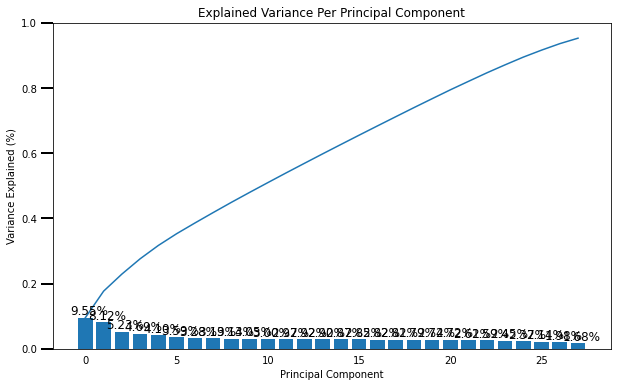

In [108]:
def pca_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca_plot(pca)

In [109]:
#Create sparse matrices to run the scikit multilearn algorithms

X_train_pca = lil_matrix(X_train_pca).toarray()
y_train = lil_matrix(y_train).toarray()
X_test_pca = lil_matrix(X_test_pca).toarray()
y_test = lil_matrix(y_test).toarray()

In [110]:
# using binary relevance
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

BR_classifier = BinaryRelevance(GaussianNB())
# train
BR_classifier.fit(X_train, y_train)
# predict
predictions = BR_classifier.predict(X_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))


Accuracy =  0.6025241763645304
--- Run time: 0.0 mins ---


In [111]:
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

CC_classifier = ClassifierChain(GaussianNB())

# train
CC_classifier.fit(X_train, y_train)

# predict
predictions = CC_classifier.predict(X_test)

accuracy_score(y_test,predictions)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Test accuracy is 0.8616620226192427
--- Run time: 0.0 mins ---


In [112]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

LP_classifier = LabelPowerset(GaussianNB())

# train
LP_classifier.fit(X_train, y_train)

# predict
predictions = LP_classifier.predict(X_test)

accuracy_score(y_test,predictions)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Test accuracy is 0.7402065235207343
--- Run time: 0.01 mins ---


In [113]:
start_time = time.time()

MLKNN_classifier = MLkNN(k=1)

# train
MLKNN_classifier.fit(X_train_pca, y_train)

# predict mlknn = 1
predictions = MLKNN_classifier.predict(X_test_pca)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy =  0.9991804622193083
--- Run time: 0.23 mins ---
